In [1]:
## All necessary modules as well as different functions that will be used in this work are explicit here.
#import all neccesary modules
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import pickle,gzip
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn import tree
import graphviz
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
#import modules created 
import my_utils
import missing_val_imput
import feature_select
import preprocessing
import adhoc_transf

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Classifier models to use
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef

import joblib
#Too see all columns when describe or head is called
pd.set_option('display.max_columns', 15)

#importing file into a pandas dataframe from UCI repository
#https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records#
path_data=r'C:\Users\mariasiouzou\Documents\ΣΙΟΥΖΟΥ ΜΑΡΙΑ ΠΤΥΧΙΑΚΗ\Heart_Failure_Predictor-master\heart_failure_clinical_records_dataset.csv'

df=pd.read_csv(path_data)

df.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2        1     7            1  
3        0     7            1  
4        0     8            1

In [2]:
def rand_jitter(arr):
    np.random.seed(42)
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

norm = np.linalg.norm
import random
from random import sample 

def SMOTE(data, sampling_rate, n_neigh, random_state=42):
    random.seed(random_state)
    new_samples = []
    
    if sampling_rate==0:
        return
    
    if sampling_rate>n_neigh: return      
    data = data.reset_index(drop=True)

    n_samples = data.count()[0]

    for i in range(n_samples):
        dists = []
        for j in range(n_samples):
            if i==j: continue
            dists.append((j, norm(data.loc[i]-data.loc[j])))    
        
        topk = sorted(dists, key=lambda s: s[1])[:n_neigh]
        neighs = sample(topk, sampling_rate)

        for neigh in neighs:
            alpha = random.random()
            new_samples.append(data.loc[i] + alpha * (data.loc[neigh[0]]-data.loc[i]))
            
    return new_samples

In [3]:
#############################
##Step 0 Train-Test splitting
#############################
#Before starting to clean data, lets split train set and data set with stratrification on y=DEATH_EVENT

train_set,test_set=train_test_split(df, test_size=0.3, random_state=42, stratify=df["DEATH_EVENT"])

    
train_set['DEATH_EVENT'].value_counts()
test_set['DEATH_EVENT'].value_counts()
    
#lets back up the split just in case
train_set_copy=train_set.copy()
test_set_copy=test_set.copy()

X_train=train_set_copy.drop('DEATH_EVENT',axis=1)
y_train=train_set_copy['DEATH_EVENT'].copy()

X_test=test_set_copy.drop('DEATH_EVENT',axis=1)
y_test=test_set_copy['DEATH_EVENT'].copy()

#Lets define numeric and category features
numerical_features=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
category_features= ['anaemia','high_blood_pressure','diabetes','sex', 'smoking']

all_features = category_features.copy()
all_features.extend(numerical_features)  

n_to_sample = len(train_set[train_set.DEATH_EVENT==0]) - len(train_set[train_set.DEATH_EVENT==1])
new_samples = SMOTE(train_set[train_set["DEATH_EVENT"]==1][all_features],
                    sampling_rate = 1, n_neigh = 50)
n_to_sample1 = len(test_set[test_set.DEATH_EVENT==0]) - len(test_set[test_set.DEATH_EVENT==1])
new_samples1 = SMOTE(test_set[test_set["DEATH_EVENT"]==1][all_features],
                    sampling_rate = 1, n_neigh = 50)

# categorical attributes need to be fixed
for s in new_samples:
   
    train_sm = train_set.append(new_samples)
    train_sm["DEATH_EVENT"].fillna(1, inplace=True)
    
for s1 in new_samples1:
   
    test_sm = test_set.append(new_samples1)
    test_sm["DEATH_EVENT"].fillna(1, inplace=True)

    
X_train=train_sm.drop('DEATH_EVENT',axis=1)
y_train=train_sm['DEATH_EVENT'].copy()

X_test=test_sm.drop('DEATH_EVENT',axis=1)
y_test=test_sm['DEATH_EVENT'].copy()  
    




In [4]:
############################
##Step -1 Pipeline creation for data preparation
#############################
#Class for correcting misspelling of features and target columns
#Due to a problem with the import with adhoc_transf
from sklearn.base import BaseEstimator, TransformerMixin
class ageRounder(BaseEstimator, TransformerMixin):
    def rounder (self,df):
    #Some fetures content seems to have the character \t.
    #Let's remove such character for the sake of consistency
        print('\n>>>>>>>>Calling rounder')      
        df['age']=np.around(df.loc[:,'age'])
        return df
    
    def __init__(self):
        print('\n>>>>>>>>Calling init() from ageRounder')
            
    def fit(self, X, y=None):
        print('\n>>>>>>>>Calling fit() from ageRounder')
        return self
    
    def transform(self,X,y=None):
        print('\n>>>>>>>>Calling transform() from ageRounder')        
        df=self.rounder(X)       
        return df
    
    def fit_transform(self, X, y=None,):
        return self.fit(X, y).transform(X, y)
    
class Feature_Selector(BaseEstimator, TransformerMixin):
    #filter_num: performing ANOVA valid for numeric input and category output
    #filter_cat: performing chi2 valid for category input and category output
    #filter_mutinf:performing mutual information valid for numeric/category input and category output
    #wrapper_RFECV: performing RFECV with two optional regressor LogisticRegression(by defaurl) or SVR valid for numeric/category input and category output
    
    #def __init__(self,y_train,strategy='wrapper_RFECV',k_out_features=5, rfe_estimator='LogisticRegression'):       
    def __init__(self,strategy='wrapper_RFECV',k_out_features=5, rfe_estimator='LogisticRegression'):
        print('\n>>>>>>>>Calling init() from Feature_Selector')
        
        #self.y_train=y_train
        self.strategy=strategy
        self.k_out_features=k_out_features
        self.rfe_estimator=rfe_estimator
        
        if self.strategy=='filter_num':
            self.feat_sel=SelectKBest(score_func=f_classif, k=self.k_out_features)
            
        if self.strategy=='filter_cat':
            self.feat_sel=SelectKBest(score_func=chi2, k=self.k_out_features)
            
        if self.strategy=='filter_mutinf':
            self.feat_sel=SelectKBest(score_func=mutual_info_classif, k=self.k_out_features)
            
        if self.strategy=='wrapper_RFECV':
            if self.rfe_estimator=='LogisticRegression':
                self.model=LogisticRegression(solver='lbfgs', max_iter=2000)
            if self.rfe_estimator=='SVR':
                self.model=SVR(kernel='linear')
            self.feat_sel=RFECV(self.model)
        
        if self.strategy=='wrapper_RFE':
            if self.rfe_estimator=='LogisticRegression':
                self.model=LogisticRegression(solver='lbfgs', max_iter=2000)
            if self.rfe_estimator=='SVR':
                self.model=SVR(kernel='linear')
            self.feat_sel=RFE(self.model, n_features_to_select=k_out_features)
        
        
    def fit(self,X,y=None):
        print('\n>>>>>>>>Calling fit() from Feature_Selector')
        #index=X.index
        self.y_train=y
        #print('\n********Inside fit() from Feature_Selector y_train length:', self.y_train.size)        
        #print('\n********Calling fit() from Feature_Selector X length: ', X.shape[0])
        
        self.feat_sel.fit(X,self.y_train)
        return self
    
    def transform(self,X,y=None):
        print('\n>>>>>>>>Calling transform() from Feature_Selector')
        X_pruned=self.feat_sel.transform(X)
        return X_pruned
        
            
        

In [5]:
###### Pipeline option a. parallel pipeline

pipeline_numeric_feat= Pipeline([('round',ageRounder()),                                 
                                 ('scaler', MinMaxScaler())
                                 ])

pipeline_numbranch=Pipeline([('num_feat',pipeline_numeric_feat),
                             ('feat_sel_num',Feature_Selector(strategy='wrapper_RFECV'))
                            ])

pipeline_num_featsel=Pipeline([('feat_sel_num',Feature_Selector(strategy='wrapper_RFECV'))])
# pipeline_category_feat= Pipeline(['features_select',feature_select.Feature_Selector(strategy='wrapper_RFECV')
#                         ])

dataprep_parallelpipe=ColumnTransformer([('numeric_pipe',pipeline_numbranch,numerical_features),
                                 ('category_pipe',Feature_Selector(strategy='wrapper_RFECV'), category_features)
                                ])


#############################
##Step 3 Classifier initialization
#############################
#Several ensemble classifier with Cross validation will be applied
#we take decision tree as base classifier

#Init the clasfifier

dectree_clf=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=7, random_state=42)
rndforest_clf=RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=3)
extratree_clf=ExtraTreesClassifier(n_estimators=100, random_state=42)
ada_clf= AdaBoostClassifier(n_estimators=100, random_state=42)
gradboost_clf=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=7, random_state=42)
xgboost_clf= xgb.XGBClassifier(colsample_bytree=0.8, learning_rate=1.0, max_depth=7,
               random_state=42, reg_alpha=0.005, subsample=0.8)
svm_clf=SVC(kernel="rbf", random_state=42, probability=True, C = 1)
knn_clf= KNeighborsClassifier(n_neighbors=3)
naive_clf=GaussianNB()


#############################
##Step 4 Scoring initialization
#############################

#Lets define the scoring for the GridSearchCV
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'precision':make_scorer(precision_score),
    'f1':make_scorer(f1_score),
    'roc_auc':make_scorer(roc_auc_score),
    'mcc':make_scorer(matthews_corrcoef)    
}


>>>>>>>>Calling init() from ageRounder

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector


In [6]:
#########################
#{'clf': XGBClassifier(colsample_bytree=0.8, learning_rate=1, max_depth=7,
 #             random_state=42, reg_alpha=0.005, subsample=0.8),
    #  'data_prep__category_pipe__k_out_features': 2, 
    #'data_prep__category_pipe__strategy': 'filter_cat', 
    #'data_prep__numeric_pipe__feat_sel_num__k_out_features': 3, 
    #'data_prep__numeric_pipe__feat_sel_num__strategy': 'filter_num'}
#win_model=clf_v41.best_estimator_

#The features selected in the win_model were:
#anaemia, time, ejection_fraction, serum_creatinine 

X_train_feat=X_train[['anaemia','ejection_fraction','serum_creatinine','time','high_blood_pressure']].copy()
X_test_feat=X_test[['anaemia','ejection_fraction','serum_creatinine','time','high_blood_pressure']].copy()

#A Decision tree with the max_depth of XGBoost (equals to 3) and the feature selection results will be made
#to show it graphically
num_feat_sel=['ejection_fraction','serum_creatinine','time','high_blood_pressure']
minmaxtrain=MinMaxScaler()
minmaxtest=MinMaxScaler()

X_train_feat[num_feat_sel]=minmaxtrain.fit_transform(X_train_feat[num_feat_sel])
X_test_feat[num_feat_sel]=minmaxtest.fit_transform(X_test_feat[num_feat_sel])

X_train_feat.head()





anaemia  ejection_fraction  serum_creatinine      time  \
186      0.0           0.538462          0.011236  0.613139   
258      1.0           0.153846          0.033708  0.824818   
104      0.0           0.538462          0.202247  0.302920   
161      1.0           0.307692          0.033708  0.427007   
263      1.0           0.692308          0.056180  0.850365   

     high_blood_pressure  
186                  0.0  
258                  0.0  
104                  1.0  
161                  0.0  
263                  0.0

In [7]:
######################
#Lets explore the feature importance of the winner model
#win_model.get_params().keys()

from matplotlib import pyplot
# plot feature importance
from xgboost import plot_importance
#plot_importance(win_model.named_steps['clf'])
#pyplot.show()

#Build the best estimator from scratch to see the feature importances
X_train_feat_best=X_train_feat.copy()
X_test_feat_best=X_test_feat.copy()
X_train_feat_best.head()

#Fitting the best estimator with pruned dataset and see their future importance
xgboost_clf.fit(X_train_feat_best,y_train)

#To explain the future importance let's predict the train set's samples
#y_pred_xgboost=xgboost_clf.predict(X_test_feat_best)
y_pred_xgboost=xgboost_clf.predict(X_train_feat_best)

[16:51:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mariasiouzou\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### 1. Feature importance analysis with XGBoost builtin function

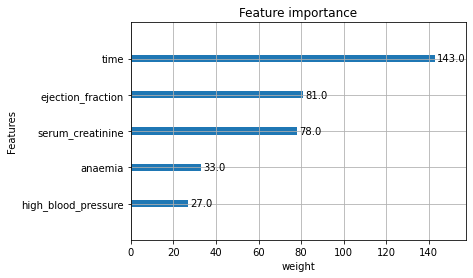

In [8]:
#Showing the importance calculated by weight
plot_importance(xgboost_clf, xlabel="weight")
pyplot.show()

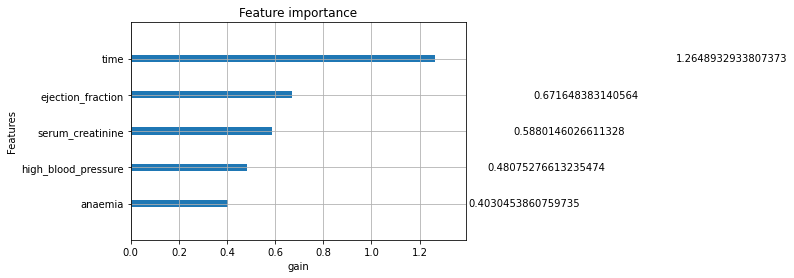

In [13]:
#Showing the importance calculated by gain
plot_importance(xgboost_clf, xlabel="gain",importance_type="gain")
pyplot.show()

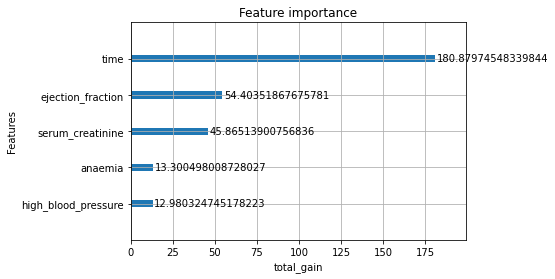

In [14]:
#Showing the importance calculated by total_gain
plot_importance(xgboost_clf, xlabel="total_gain",importance_type="total_gain")
pyplot.show()

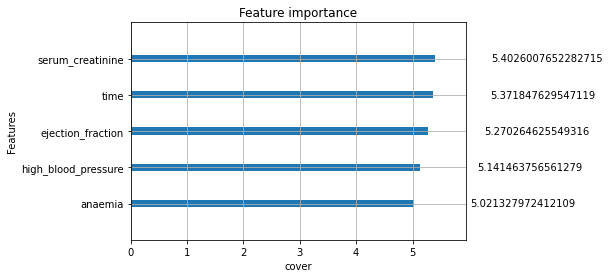

In [15]:
#Showing the importance calculated by cover
plot_importance(xgboost_clf, xlabel="cover",importance_type="cover")
pyplot.show()

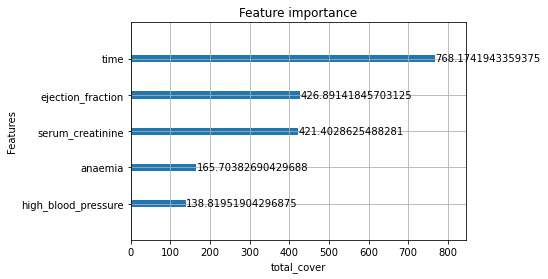

In [16]:
#Showing the importance calculated by total_cover
plot_importance(xgboost_clf, xlabel="total_cover",importance_type="total_cover")
pyplot.show()

### 2. Feature permutation importance analysis with Eli5

In [17]:
import eli5
from eli5 import show_weights
features = np.array(X_train_feat_best.columns)
print('Feature ranking considering gain')
eli5.explain_weights_xgboost(xgboost_clf, feature_names=features, importance_type='gain')

Feature ranking considering gain


Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=0.8,\n              enable_categorical=False, gamma=0, gpu_id=-1,\n              importance_type=None, interaction_constraints='',\n              learning_rate=1.0, max_delta_step=0, max_depth=7,\n              min_child_weight=1, missing=nan, monotone_constraints='()',\n              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',\n              random_state=42, reg_alpha=0.005, reg_lambda=1,\n              scale_pos_weight=1, subsample=0.8, tree_method='exact',\n              validate_parameters=1, verbosity=None)", description='\nXGBoost feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='time', weight=0.37111554, std=None, value=None), FeatureWeight(feature='ejection_fraction', weight=0.19705942, std=None, value=None), FeatureWeight(feature='serum_creatinine', weight=0.17252155, std=None, value=None), FeatureWeight(feature='high_blood_pressure', weight=0.14105128, std=None, value=None), FeatureWeight(feature='anaemia', weight=0.11825219, std=None, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [18]:
print('Feature ranking considering weight')
eli5.explain_weights_xgboost(xgboost_clf, feature_names=features, importance_type='weight')

Feature ranking considering weight


Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=0.8,\n              enable_categorical=False, gamma=0, gpu_id=-1,\n              importance_type=None, interaction_constraints='',\n              learning_rate=1.0, max_delta_step=0, max_depth=7,\n              min_child_weight=1, missing=nan, monotone_constraints='()',\n              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',\n              random_state=42, reg_alpha=0.005, reg_lambda=1,\n              scale_pos_weight=1, subsample=0.8, tree_method='exact',\n              validate_parameters=1, verbosity=None)", description='\nXGBoost feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='time', weight=0.39502764, std=None, value=None), FeatureWeight(feature='ejection_fraction', weight=0.22375691, std=None, value=None), FeatureWeight(feature='serum_creatinine', weight=0.21546961, std=None, value=None), FeatureWeight(feature='anaemia', weight=0.09116022, std=None, value=None), FeatureWeight(feature='high_blood_pressure', weight=0.07458564, std=None, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [19]:
print('Feature ranking considering cover')
eli5.explain_weights_xgboost(xgboost_clf, feature_names=features, importance_type='cover')

Feature ranking considering cover


Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=0.8,\n              enable_categorical=False, gamma=0, gpu_id=-1,\n              importance_type=None, interaction_constraints='',\n              learning_rate=1.0, max_delta_step=0, max_depth=7,\n              min_child_weight=1, missing=nan, monotone_constraints='()',\n              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',\n              random_state=42, reg_alpha=0.005, reg_lambda=1,\n              scale_pos_weight=1, subsample=0.8, tree_method='exact',\n              validate_parameters=1, verbosity=None)", description='\nXGBoost feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='serum_creatinine', weight=0.20614709, std=None, value=None), FeatureWeight(feature='time', weight=0.20497364, std=None, value=None), FeatureWeight(feature='ejection_fraction', weight=0.20109753, std=None, value=None), FeatureWeight(feature='high_blood_pressure', weight=0.19618288, std=None, value=None), FeatureWeight(feature='anaemia', weight=0.19159886, std=None, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [20]:
y_pred_xgboost

array([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [21]:
#true negative
#explaining prediction patient that survive to heart failure (true negative)
index = 4
#print('Actual Label:', y_test.iloc[index])
#print('Predicted Label:', y_pred_xgboost[index])
#eli5.explain_prediction_xgboost(xgboost_clf, X_test_feat_best.iloc[index], feature_names=features)

#Use of trainset to explain the prediction
print('Actual Label:', y_train.iloc[index])
print('Predicted Label:', y_pred_xgboost[index])
#eli5.explain_prediction_xgboost(xgboost_clf, X_train_feat_best.iloc[index], feature_names=features)

eli5.explain_prediction_xgboost(xgboost_clf, X_train_feat_best.iloc[index], feature_names=features)

Actual Label: 0.0
Predicted Label: 0.0


Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=0.8,\n              enable_categorical=False, gamma=0, gpu_id=-1,\n              importance_type=None, interaction_constraints='',\n              learning_rate=1.0, max_delta_step=0, max_depth=7,\n              min_child_weight=1, missing=nan, monotone_constraints='()',\n              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',\n              random_state=42, reg_alpha=0.005, reg_lambda=1,\n              scale_pos_weight=1, subsample=0.8, tree_method='exact',\n              validate_parameters=1, verbosity=None)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='time', weight=3.559007154289274, std=None, value=0.8503649635036497), FeatureWeight(feature='serum_creatinine', weight=2.5722537447523264, std=None, value=0.056179775280898875), FeatureWeight(feature='ejection_fraction', weight=1.681972199707176, std=None, value=0.6923076923076923), FeatureWeight(feature='<BIAS>', weight=0.3040513763542301, std=None, value=1.0)], neg=[FeatureWeight(feature='anaemia', weight=-0.3190610949666264, std=None, value=1.0), FeatureWeight(feature='high_blood_pressure', weight=-0.0034752587963810255, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=0.99958825, score=-7.794748121340002, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [22]:
#true positive
# predicting patient that survive to heart failure
index = 7
#print('Actual Label:', y_test.iloc[index])
#print('Predicted Label:', y_pred_xgboost[index])
#eli5.explain_prediction(xgboost_clf, X_test_feat_best.iloc[index], feature_names=features)

#Use of trainset to explain the prediction
print('Actual Label:', y_train.iloc[index])
print('Predicted Label:', y_pred_xgboost[index])
eli5.explain_prediction(xgboost_clf, X_train_feat_best.iloc[index], feature_names=features)

Actual Label: 1.0
Predicted Label: 1.0


Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=0.8,\n              enable_categorical=False, gamma=0, gpu_id=-1,\n              importance_type=None, interaction_constraints='',\n              learning_rate=1.0, max_delta_step=0, max_depth=7,\n              min_child_weight=1, missing=nan, monotone_constraints='()',\n              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',\n              random_state=42, reg_alpha=0.005, reg_lambda=1,\n              scale_pos_weight=1, subsample=0.8, tree_method='exact',\n              validate_parameters=1, verbosity=None)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='time', weight=5.715025746730071, std=None, value=0.014598540145985401), FeatureWeight(feature='serum_creatinine', weight=2.2170285752677983, std=None, value=0.1797752808988764), FeatureWeight(feature='ejection_fraction', weight=1.131554958768607, std=None, value=0.38461538461538464), FeatureWeight(feature='anaemia', weight=0.6024749911348364, std=None, value=1.0), FeatureWeight(feature='high_blood_pressure', weight=0.1326658855529182, std=None, value=1.0)], neg=[FeatureWeight(feature='<BIAS>', weight=-0.3040513763542301, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.9999248, score=9.494698781099999, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

Explanation of the BIAS term here: https://stackoverflow.com/questions/49402701/eli5-explaining-prediction-xgboost-model

#### 2.1 show_weights and explain_prediction as eli5 tutorial

Extracted from tutorial in https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html#xgboost-titanic-tutorial

In [23]:

from sklearn.feature_extraction import DictVectorizer
booster = xgboost_clf.get_booster()
vec = DictVectorizer()

original_feature_names = booster.feature_names
#booster.feature_names = vec.get_feature_names()

print(booster.get_dump()[0])
# recover original feature names
booster.feature_names = original_feature_names

0:[time<0.254477024] yes=1,no=2,missing=1
	1:[ejection_fraction<0.682528377] yes=3,no=4,missing=3
		3:leaf=1.69205129
		4:leaf=0.398000002
	2:[ejection_fraction<0.217535153] yes=5,no=6,missing=5
		5:[time<0.653284669] yes=7,no=8,missing=7
			7:[anaemia<0.890681028] yes=9,no=10,missing=9
				9:[ejection_fraction<0.133032769] yes=13,no=14,missing=13
					13:leaf=1.27090907
					14:leaf=0.180000007
				10:[time<0.290145993] yes=15,no=16,missing=15
					15:leaf=0.664444447
					16:leaf=-0.497500002
			8:[time<0.776525497] yes=11,no=12,missing=11
				11:leaf=-0.997500002
				12:leaf=0.497500002
		6:leaf=-1.62944448



In [24]:
from eli5 import show_weights
show_weights(xgboost_clf, show_feature_values=True)

In [25]:
# explaining prediction patient that survive to heart failure (true negative)
index = 4
#print('Actual Label:', y_test.iloc[index])
#print('Predicted Label:', y_pred_xgboost[index])
#eli5.explain_prediction_xgboost(xgboost_clf, X_test_feat_best.iloc[index], feature_names=features)

#Use of trainset to explain the prediction
print('Actual Label:', y_train.iloc[index])
print('Predicted Label:', y_pred_xgboost[index])
#eli5.explain_prediction_xgboost(xgboost_clf, X_train_feat_best.iloc[index], feature_names=features)

eli5.explain_prediction_xgboost(xgboost_clf, X_train_feat_best.iloc[index], targets= [True], feature_names=features )

Actual Label: 0.0
Predicted Label: 0.0


Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=0.8,\n              enable_categorical=False, gamma=0, gpu_id=-1,\n              importance_type=None, interaction_constraints='',\n              learning_rate=1.0, max_delta_step=0, max_depth=7,\n              min_child_weight=1, missing=nan, monotone_constraints='()',\n              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',\n              random_state=42, reg_alpha=0.005, reg_lambda=1,\n              scale_pos_weight=1, subsample=0.8, tree_method='exact',\n              validate_parameters=1, verbosity=None)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='anaemia', weight=0.3190610949666264, std=None, value=1.0), FeatureWeight(feature='high_blood_pressure', weight=0.0034752587963810255, std=None, value=0.0)], neg=[FeatureWeight(feature='time', weight=-3.559007154289274, std=None, value=0.8503649635036497), FeatureWeight(feature='serum_creatinine', weight=-2.5722537447523264, std=None, value=0.056179775280898875), FeatureWeight(feature='ejection_fraction', weight=-1.681972199707176, std=None, value=0.6923076923076923), FeatureWeight(feature='<BIAS>', weight=-0.3040513763542301, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.00041172345, score=-7.794748121340002, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

#### 2.2 Using test set for explainability

In [26]:
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgboost_clf, random_state=1).fit(X_test_feat_best, y_test)
eli5.show_weights(perm, feature_names = X_test_feat_best.columns.tolist())

It seems that ICE does not perform well with XGBoost (a deviation to take a RandomForest could be applied)

### 4. Explanation through Partial dependence plots


#### 4.1 1D partial dependence plot

In [27]:
#import packages
from pdpbox import pdp, get_dataset, info_plots

#pdp_rad = pdp.pdp_isolate(model=xgboost_clf, dataset=X_train_feat_best, model_features=X_train_feat_best.columns, feature='time')

#building pdp diagrama for each feature: 'anaemia','ejection_fraction','serum_creatinine','time'
pdp_time= pdp.pdp_isolate(model=xgboost_clf, dataset=X_train_feat_best, model_features=X_train_feat_best.columns, feature='time', num_grid_points=20)
pdp_ejection_fraction= pdp.pdp_isolate(model=xgboost_clf, dataset=X_train_feat_best, model_features=X_train_feat_best.columns, feature='ejection_fraction')
pdp_serum_creatinine= pdp.pdp_isolate(model=xgboost_clf, dataset=X_train_feat_best, model_features=X_train_feat_best.columns, feature='serum_creatinine')
pdp_anaemia= pdp.pdp_isolate(model=xgboost_clf, dataset=X_train_feat_best, model_features=X_train_feat_best.columns, feature='anaemia')

In [28]:
#Another option is to try with the test_set

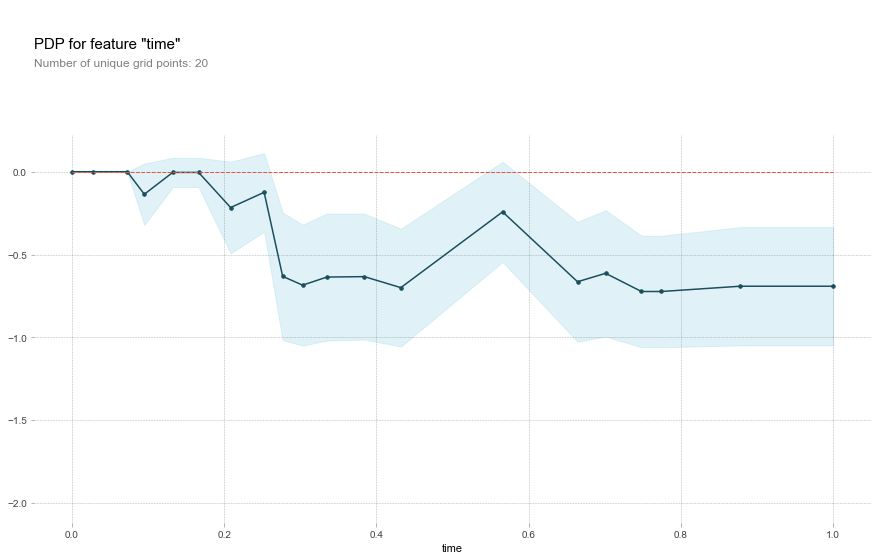

In [29]:
#plotting for feature "time"
pdp.pdp_plot(pdp_time, 'time')
plt.show()
#The x-axis is depicted in minmax scale

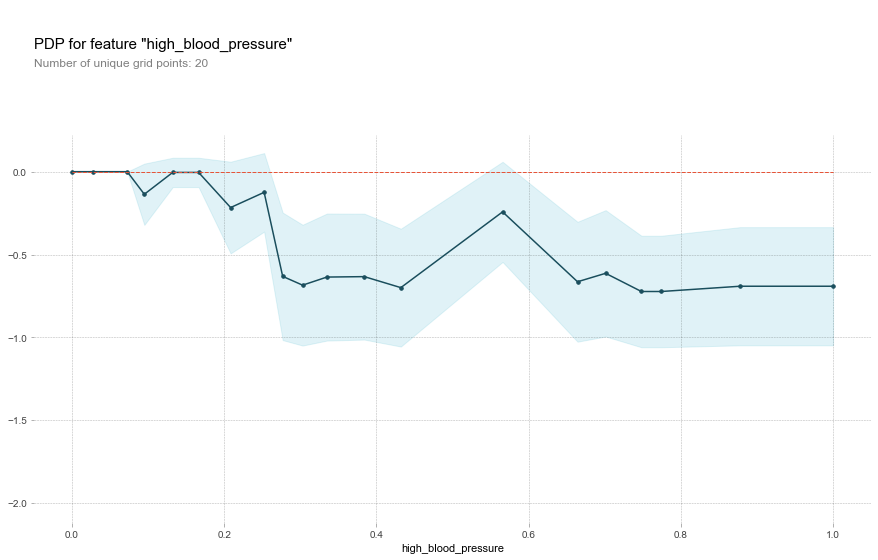

In [30]:
pdp.pdp_plot(pdp_time, 'high_blood_pressure')
plt.show()

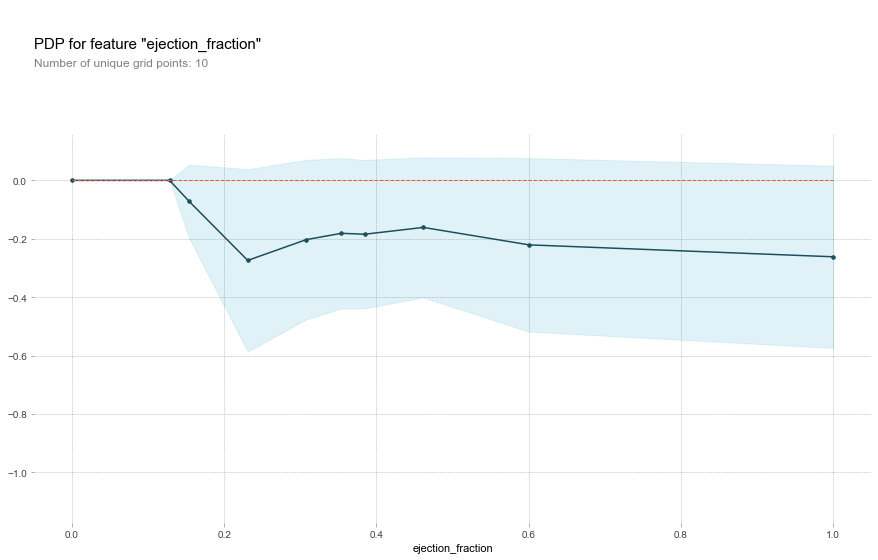

In [31]:
#plotting for feature "ejection_fraction"
pdp.pdp_plot(pdp_ejection_fraction, 'ejection_fraction')
plt.show()
#The x-axis is depicted in minmax scale

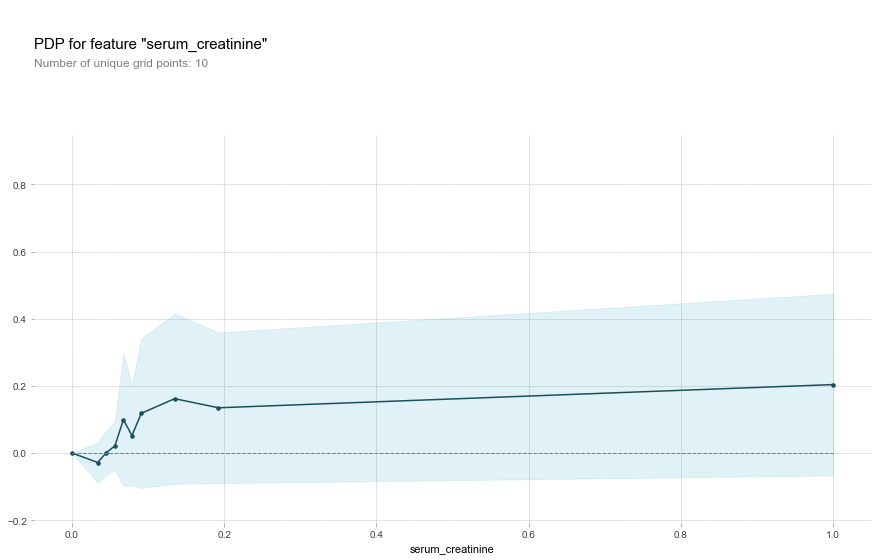

In [32]:
#plotting for feature "serum_creatinine"
pdp.pdp_plot(pdp_serum_creatinine, 'serum_creatinine')
plt.show()
#The x-axis is depicted in minmax scale

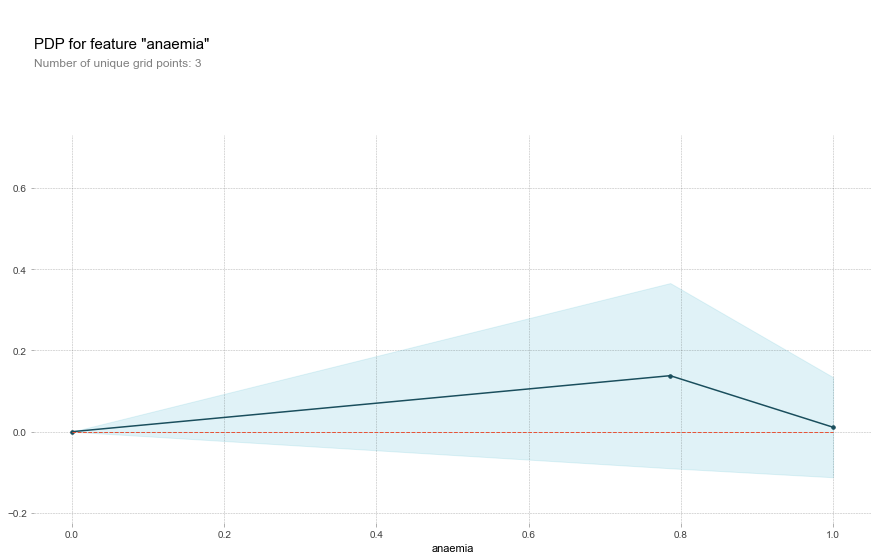

In [33]:
#plotting for feature "anaemia"
pdp.pdp_plot(pdp_anaemia, 'anaemia')
plt.show()
#The x-axis is depicted in minmax scale

#### 4.2 2D Partial Dependence Plots

In [34]:
#Lets define the different combinations for the 4 features selected
feat_comb1=['time','ejection_fraction']
feat_comb2=['time','serum_creatinine']
feat_comb3=['ejection_fraction','serum_creatinine']

comb1=pdp.pdp_interact(model=xgboost_clf, dataset=X_train_feat_best, model_features=X_train_feat_best.columns, features=feat_comb1)
comb2=pdp.pdp_interact(model=xgboost_clf, dataset=X_train_feat_best, model_features=X_train_feat_best.columns, features=feat_comb2)
comb3=pdp.pdp_interact(model=xgboost_clf, dataset=X_train_feat_best, model_features=X_train_feat_best.columns, features=feat_comb3)

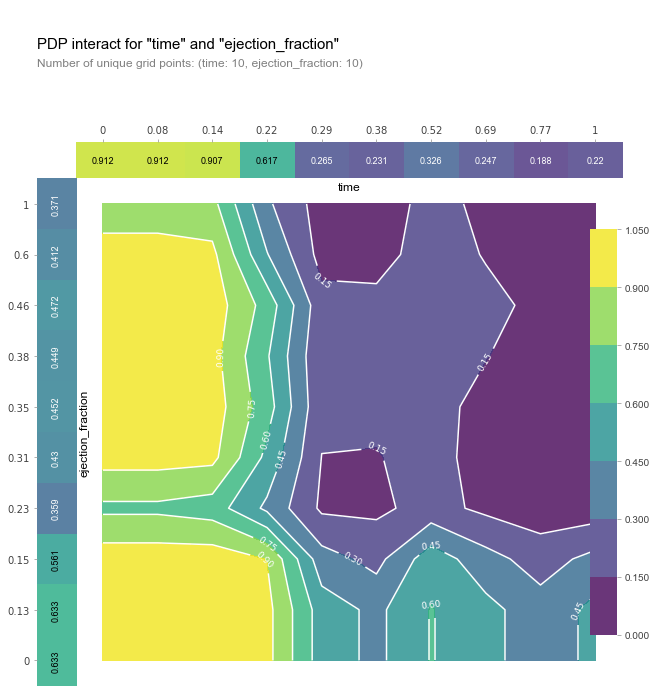

In [35]:
#Ploting ['time','ejection_fraction']
pdp.pdp_interact_plot(pdp_interact_out=comb1, feature_names=feat_comb1, plot_type='contour', x_quantile=True, plot_pdp=True)
plt.show()

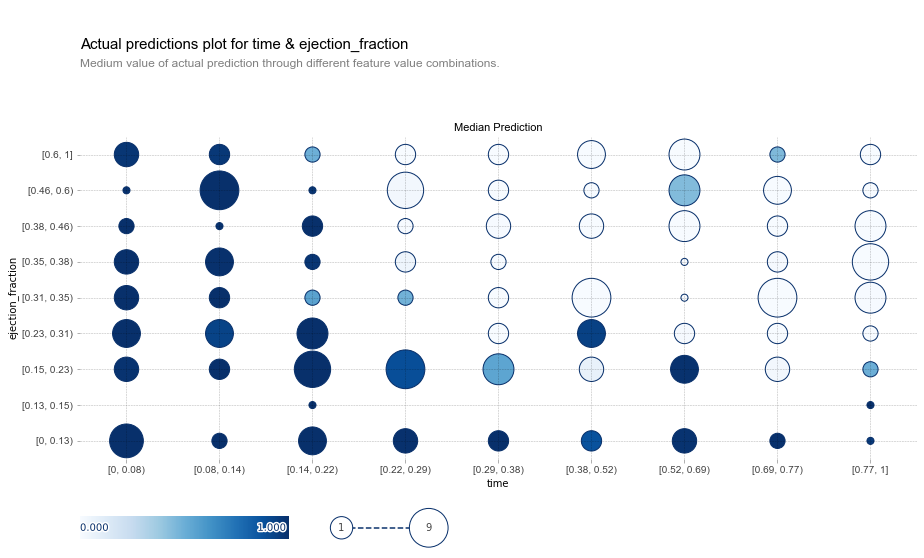

In [36]:

fig, axes, summary_df = info_plots.actual_plot_interact(
model=xgboost_clf, X=X_train_feat_best, features=feat_comb1, feature_names=feat_comb1
)

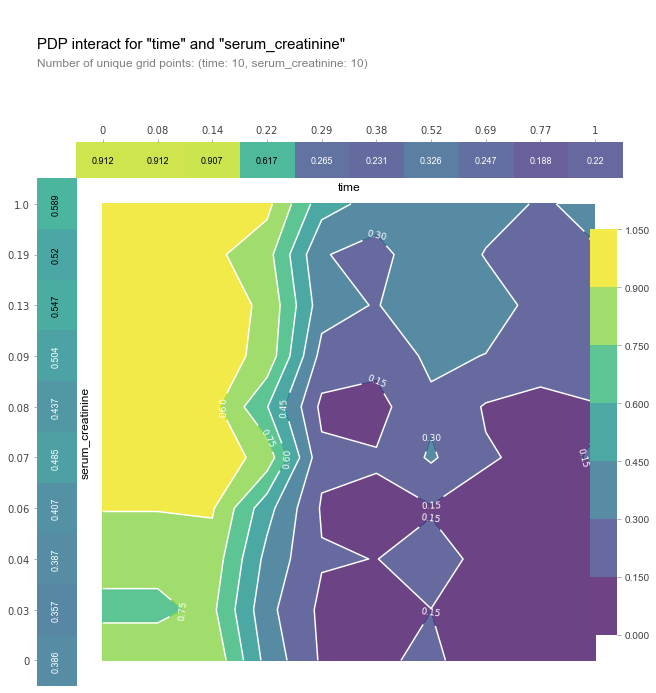

In [37]:
#Ploting ['time','serum_creatinine']
pdp.pdp_interact_plot(pdp_interact_out=comb2, feature_names=feat_comb2, plot_type='contour', x_quantile=True, plot_pdp=True)
plt.show()

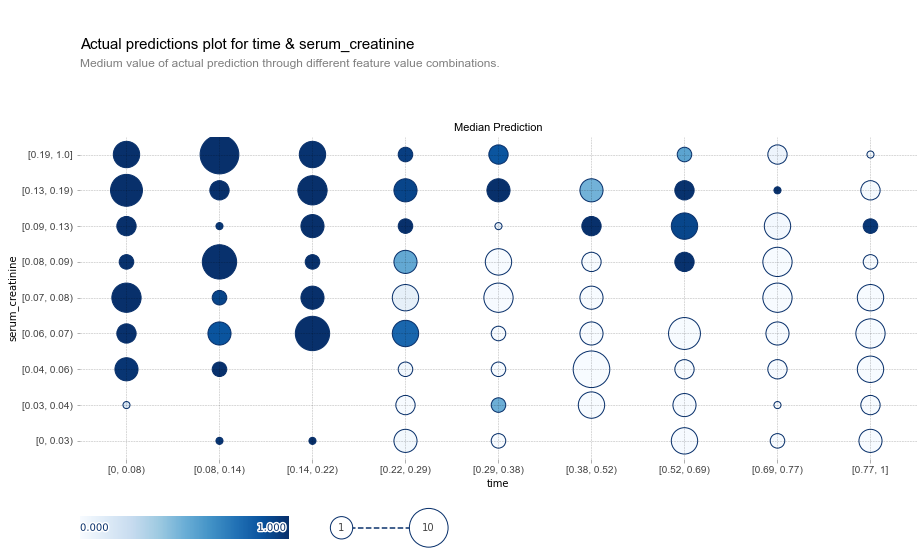

In [38]:
fig, axes, summary_df = info_plots.actual_plot_interact(
model=xgboost_clf, X=X_train_feat_best, features=feat_comb2, feature_names=feat_comb2
)

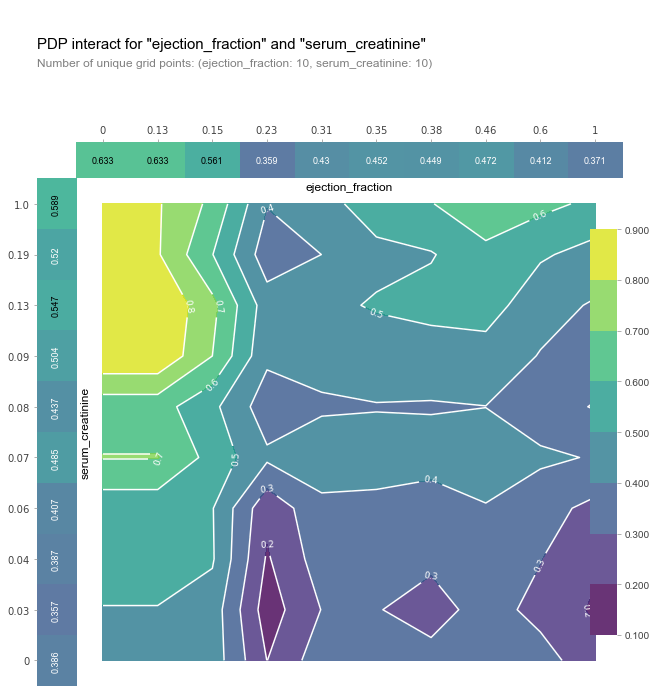

In [39]:
#Ploting ['ejection_fraction','serum_creatinine'']
pdp.pdp_interact_plot(pdp_interact_out=comb3, feature_names=feat_comb3, plot_type='contour', x_quantile=True, plot_pdp=True)
plt.show()

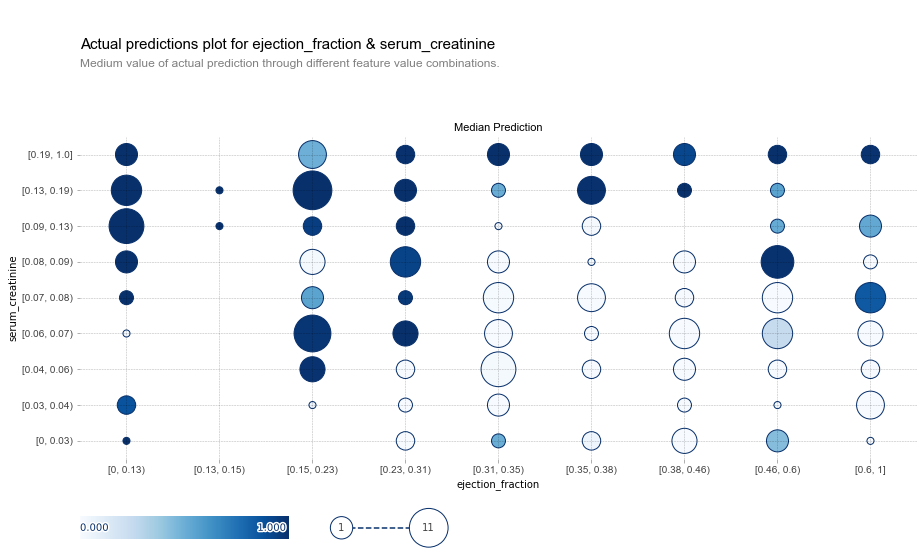

In [40]:

fig, axes, summary_df = info_plots.actual_plot_interact(
model=xgboost_clf, X=X_train_feat_best, features=feat_comb3, feature_names=feat_comb3
)

### 5. Plotting Feature Contributions against Feature Values


### 6. Explainability by SHAP

In [43]:
# Let's try with SHAP method
import shap
shap.initjs()
explainer=shap.TreeExplainer(xgboost_clf)
shap_values=explainer.shap_values(X_test_feat_best)

#### 5.1 Local explainability by SHAP

In [42]:
# visualize the explanation of patient that survive to heart failure (true negative)
shap.force_plot(explainer.expected_value, shap_values[4,:], X_test_feat_best.iloc[4,:])


In [189]:
X_test_feat_best.head()

anaemia  ejection_fraction  serum_creatinine      time  \
146      0.0           0.347826          0.018182  0.377698   
226      1.0           0.239130          0.127273  0.712230   
10       1.0           0.521739          0.618182  0.010791   
242      0.0           0.456522          0.090909  0.737410   
118      1.0           1.000000          0.054545  0.312950   

     high_blood_pressure  
146                  0.0  
226                  0.0  
10                   1.0  
242                  0.0  
118                  1.0

In [190]:
shap_values

array([[ 3.41977537e-01,  6.92039132e-01, -1.10928679e+00,
        -3.37548542e+00,  4.41689640e-01],
       [ 1.00092679e-01, -9.24285412e-01,  1.63760436e+00,
        -1.63153613e+00,  1.07416511e-01],
       [ 1.17876813e-01,  1.87099469e+00,  2.03497434e+00,
         5.66426802e+00,  4.04722035e-01],
       [-4.90278125e-01, -4.61324334e-01,  7.28627801e-01,
        -4.74346733e+00, -2.11902887e-01],
       [ 9.99800861e-03, -1.42732549e+00, -2.10371590e+00,
        -4.94683743e+00, -1.08607256e+00],
       [-6.41685486e-01,  7.41260767e-01,  1.06670654e+00,
        -4.07582808e+00, -1.78716063e-01],
       [ 6.95060343e-02, -1.05553496e+00,  1.26511657e+00,
         2.14923573e+00,  3.85099053e-01],
       [-2.87507296e-01,  1.58644587e-01, -2.47570300e+00,
        -3.75169277e+00, -1.00979459e+00],
       [-4.51095045e-01,  5.55321097e-01,  4.38719034e-01,
        -4.82176924e+00,  1.91573873e-01],
       [-3.69313359e-01, -1.04997464e-01,  1.53702366e+00,
        -6.03361547e-01

In [44]:
# visualize the explanation of patient that do not survive to heart failure (true positive)
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_feat_best.iloc[2,:])


The code below is for transforming features value from its minmaxscaling value to the original

In [52]:
#the SHAP shows the following features in the attribution to the final score
#time=0.3129, 0.01079
#ejection_fraction=1
#serum creatinine=0.05455,0.6182
#To improve readability of the graph lets transform these values to their original ones
#Inverting time
X_train_feat_time=X_train[['time']].copy()
minmaxtrain_time=MinMaxScaler()
X_train_feat_time=minmaxtrain_time.fit_transform(X_train_feat_time)
time_1=minmaxtrain_time.inverse_transform(np.array(0.261).reshape(1,-1))
time_2=minmaxtrain_time.inverse_transform(np.array(0.737).reshape(1,-1))
#Inverting ejection_fraction
X_train_feat_ef=X_train[['ejection_fraction']].copy()
minmaxtrain_ef=MinMaxScaler()
X_train_feat_ef=minmaxtrain_ef.fit_transform(X_train_feat_ef)
ef_1=minmaxtrain_ef.inverse_transform(np.array(0.885).reshape(1,-1))
ef_2=minmaxtrain_ef.inverse_transform(np.array(0.192).reshape(1,-1))
ef_3=minmaxtrain_ef.inverse_transform(np.array(0.369).reshape(1,-1))
#Inverting serum_creatinine
X_train_feat_sc=X_train[['serum_creatinine']].copy()
minmaxtrain_sc=MinMaxScaler()
X_train_feat_sc=minmaxtrain_sc.fit_transform(X_train_feat_sc)
sc_1=minmaxtrain_sc.inverse_transform(np.array(0.046).reshape(1,-1))
sc_2=minmaxtrain_sc.inverse_transform(np.array(0.104).reshape(1,-1))
print ('time_1: ',time_1,'; time_2: ',time_2,'; ef_1: ',ef_1, '; ef_2: ',ef_2,'; ef_3: ',ef_3,'; sc_1: ',sc_1,'; sc_2: ',sc_2)


time_1:  [[75.514]] ; time_2:  [[205.938]] ; ef_1:  [[72.525]] ; ef_2:  [[27.48]] ; ef_3:  [[38.985]] ; sc_1:  [[0.9094]] ; sc_2:  [[1.4256]]


#### 5.2 General explainability

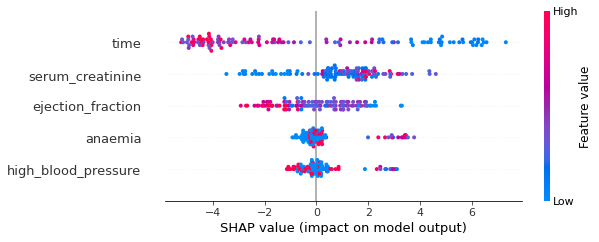

In [46]:
shap.summary_plot(shap_values, X_test_feat_best)

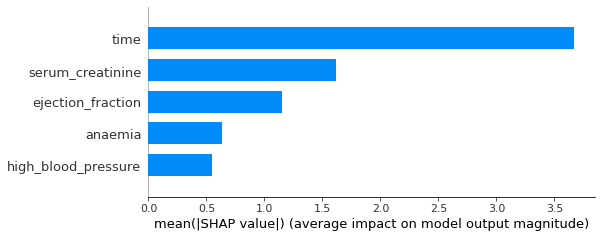

In [47]:
shap.summary_plot(shap_values, X_test_feat_best,plot_type="bar")


### 6. Explainability through LIME
Taking the code from https://maelfabien.github.io/machinelearning/Explorium_3/#6-local-interpretable-model-agnostic-explanations-lime

In [199]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train_feat_best), feature_names=np.array(X_train_feat_best.columns), class_names=np.array([0, 1]), mode="classification",discretize_continuous=False)

In [200]:
#local prediction for true positive index=7
index=7
exp = explainer.explain_instance(X_train_feat_best.iloc[index,:].values, 
                                 xgboost_clf.predict_proba, num_features=4)


In [201]:
exp.show_in_notebook(show_table = True, show_all= False)

In [202]:
index=4
exp = explainer.explain_instance(X_train_feat_best.iloc[index,:].values, 
                                 xgboost_clf.predict_proba, num_features=4)

In [203]:
exp.show_in_notebook(show_table = True, show_all= False)